# Coupled spring mass system

In this notebook we provide a simple example of the DeepMoD algorithm by applying it a simple coupled spring-mass system. 

Data was generated using: https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.training import train_deepmod, train_mse
from deepymod_torch.library_functions import library_1D_in

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(41)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

Next, we prepare the dataset.

# Generate data

In [2]:
def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, y1, x2, y2 = w
    m1, m2, k1, k2, L1, L2, b1, b2 = p

    # Create f = (x1',y1',x2',y2'):
    f = [y1,
         (-b1 * y1 - k1 * (x1 - L1) + k2 * (x2 - x1 - L2)) / m1,
         y2,
         (-b2 * y2 - k2 * (x2 - x1 - L2)) / m2]
    return f

In [3]:
# Parameter values
# Masses:
m1 = 1.0
m2 = 1.5
# Spring constants
k1 = 8.0
k2 = 40.0
# Natural lengths
L1 = 0.5
L2 = 1.0
# Friction coefficients
b1 = 0.8
b2 = 0.5

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
x1 = 0.5
y1 = 0.0
x2 = 2.25
y2 = 0.0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 4.0
numpoints = 500

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Pack up the parameters and initial conditions:
p = [m1, m2, k1, k2, L1, L2, b1, b2]
w0 = [x1, y1, x2, y2]

# Call the ODE solver.
wsol = odeint(vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)
T= np.array(t).reshape(-1,1)

# Rescale parameters 

In [4]:
T_rs = 5*T
Y_rs = wsol/np.max(np.abs(wsol),axis=0)

In [5]:
np.max(np.abs(wsol),axis=0)

array([1.22673138, 3.66677606, 2.25      , 2.40137539])

In [6]:
print(Y_rs.shape,T_rs.shape)

(500, 4) (500, 1)


Let's plot it to get an idea of the data:

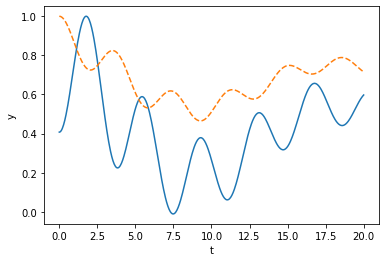

In [7]:
fig, ax = plt.subplots()
ax.plot(T_rs, Y_rs[:,0])
ax.plot(T_rs, Y_rs[:,2],'--')
ax.set_xlabel('t')
ax.set_ylabel('y')

plt.show()

In [8]:
number_of_samples = 400

idx = np.random.permutation(wsol.shape[0])
X_train = torch.tensor(T_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [9]:
print(X_train.shape, y_train.shape)

torch.Size([400, 1]) torch.Size([400, 4])


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [10]:
## Running DeepMoD
config = {'n_in': 1, 'hidden_dims': [50, 50, 50, 50, 50, 50], 'n_out': 4, 'library_function': library_1D_in, 'library_args':{'poly_order': 1, 'diff_order': 0}}

Now we instantiate the model:

In [11]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [12]:
train_deepmod(model, X_train, y_train, optimizer, 25000, {'l1': 1e-5})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      25000    100.00%               0s   8.51e-04   1.00e-04   5.24e-04   2.27e-04 
[Parameter containing:
tensor([[0.5978]], requires_grad=True), Parameter containing:
tensor([[-1.3805],
        [ 3.9830],
        [-3.8039]], requires_grad=True), Parameter containing:
tensor([[0.2231]], requires_grad=True), Parameter containing:
tensor([[ 1.6142],
        [-4.0367],
        [ 3.3915]], requires_grad=True)]
[tensor([4]), tensor([0, 2, 8]), tensor([1]), tensor([0, 2, 8])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      22700     90.80%               0s   2.56e-01   1.25e-04   2.56e-01   0.00e+00 

KeyboardInterrupt: 

Now that DeepMoD has converged, it has found the following numbers:

In [13]:
solution = model(X_train)[0].detach().numpy()

In [14]:
print('Final result:')
print(model.fit.coeff_vector[0], model.fit.coeff_vector[1],model.fit.coeff_vector[2],model.fit.coeff_vector[3])

Final result:
Parameter containing:
tensor([[0.5978]], requires_grad=True) Parameter containing:
tensor([[-1.3805],
        [ 3.9830],
        [-3.8039]], requires_grad=True) Parameter containing:
tensor([[0.2231]], requires_grad=True) Parameter containing:
tensor([[ 1.6142],
        [-4.0367],
        [ 3.3915]], requires_grad=True)


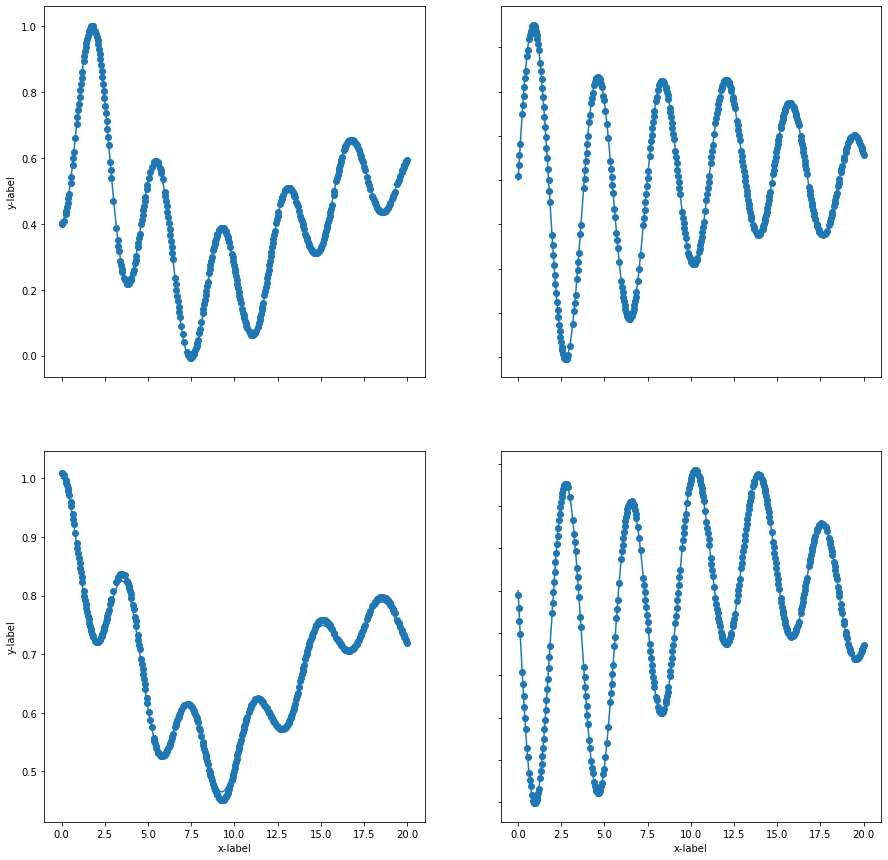

In [15]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0, 0].scatter(X_train.detach().numpy().squeeze(),solution[:,0])
axs[0, 0].plot(T_rs,Y_rs[:,0])
axs[0, 1].scatter(X_train.detach().numpy().squeeze(),solution[:,1])
axs[0, 1].plot(T_rs,Y_rs[:,1])
axs[1, 0].scatter(X_train.detach().numpy().squeeze(),solution[:,2])
axs[1, 0].plot(T_rs,Y_rs[:,2])
axs[1, 1].scatter(X_train.detach().numpy().squeeze(),solution[:,3])
axs[1, 1].plot(T_rs,Y_rs[:,3])

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()